In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/Tesi/Colab working dir'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Tesi/Colab working dir


In [0]:
import tensorflow as tf


### Helpers
def _weights(name, shape, initializer='xavier'):
  """ Helper to create an initialized Variable
  Args:
    name: name of the variable
    shape: list of ints
    initializer: 'random_normal' or 'xavier'
  Returns:
    A trainable variable
  """
  if initializer == 'random_normal':
    init = tf.random_normal_initializer(mean=0.0, stddev=0.02, dtype=tf.float32)
  elif initializer == 'xavier':
    init = tf.contrib.layers.xavier_initializer(dtype=tf.float32)
    
  var = tf.get_variable(name, shape, trainable=True, initializer=init)
  return var

def _biases(name, shape, constant=0.0):
  """ Helper to create an initialized Bias with constant
  """
  return tf.get_variable(name, shape,
            initializer=tf.constant_initializer(constant))

def _parametric_relu(_x):
  alphas = tf.get_variable('alpha', _x.get_shape()[-1],
                        initializer=tf.constant_initializer(0.01),
                        dtype=tf.float32,
                        trainable = True)
  pos = tf.nn.relu(_x)
  neg = alphas * (_x - abs(_x)) * 0.5
  
  return pos + neg

def _norm(input, is_training, norm='instance'):
  """ Use Instance Normalization or Batch Normalization or None
  """
  if norm == 'instance':
    return _instance_norm(input)
  elif norm == 'batch':
    return _batch_norm(input, is_training)
  else:
    return input

def _batch_norm(input, scope):
  """ Batch Normalization
  """
  with tf.variable_scope(scope):
    return tf.keras.layers.BatchNormalization(axis=-1)(input)

def _instance_norm(input, scope):
  """ Instance Normalization
  """
  with tf.variable_scope(scope):
      return tf.contrib.layers.instance_norm(input)

def safe_log(x, eps=1e-12):
  return tf.log(x + eps)


In [0]:
def conv(input, n_filters, w_size=3, scope='conv_0', dilation=False, regularization=False):
    with tf.variable_scope(scope):
        dilation_rate = (2, 2) if dilation else (1, 1)
        regularizer = tf.keras.regularizers.l2() if regularization else None
        conv = tf.keras.layers.Conv2D(n_filters, 
                                      w_size, 
                                      padding='same', 
                                      dilation_rate=dilation_rate, 
                                      use_bias=False,
                                      kernel_regularizer=regularizer)(input)
        return conv

def conv_block(input, n_filters, scope, dilation=True):
    with tf.variable_scope(scope) :
        x = _batch_norm(input, 'batch_norm_0')
        x = tf.nn.relu(x)
        x = conv(x, n_filters, scope='conv_0', dilation=dilation)

        return x
      
def last_block(input, n_filters, scope):
    with tf.variable_scope(scope) :
        x = tf.nn.relu(input)
        x = conv(x, n_filters, scope='conv_0')

        return x

In [0]:
#import tensorflow as tf
#import * from ops
#import utils

class Net:
  def __init__(self, name, n_filters, is_training, norm=None):
    self.name = name
    self.n_filters = n_filters
    self.reuse = False
    self.norm = norm
    self.is_training = is_training

  def __call__(self, input):
    """
    Args:
      input: batch_size x width x height x n_channels
    Returns:
      output: same size as input
    """
    with tf.variable_scope(self.name, reuse=self.reuse):
        conv0 = conv(input, n_filters, w_size=3, scope='conv_0')
        x = conv_block(conv0, n_filters, scope='block_1')
        x = conv_block(x, n_filters, scope='block_2')
        x = conv_block(x, n_filters, scope='block_3')
        res_block_0 = x+conv0
        x = conv_block(res_block_0, n_filters, scope='block_4')
        x = conv_block(x, n_filters, scope='block_5')
        x = conv_block(x, n_filters, scope='block_6')
        x = x + res_block_0 #residual connection
        x = last_block(x, 1, scope='block_7')
      
    # set reuse=True for next call
    self.reuse = True
    self.variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name)

    return x

  def sample(self, input):
    output = self.__call__(input)
    #image = utils.batch_convert2int(self.__call__(input))
    #image = tf.image.encode_jpeg(tf.squeeze(image, [0]))
    return tf.squeeze(output)


In [0]:
#import tensorflow as tf
#import ops
#import utils
#from reader import Reader
#from net import Net

REAL_LABEL = 0.9

class FusionCNN:
  def __init__(self,
               n_filters = 32,
               batch_size=8,
               norm=None,
               learning_rate=2e-4,
               beta1=0.5
              ):
    """
    Args:
      n_filters: integer, number of filters for each convolutional layer
      batch_size: integer, batch size
      norm: 'None, 'instance' or 'batch'
      learning_rate: float, learning rate for Adam
      beta1: float, momentum term of Adam
    """
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.n_filters = n_filters
    self.norm = norm

    self.is_training = tf.placeholder_with_default(True, shape=[], name='is_training')

    self.net = Net('net', n_filters=self.n_filters, is_training=self.is_training, norm=self.norm)


  def model(self, x, label):
    """
    Args:
      x: ensor of float, sample of the validation set
      label: tensor of float, label related to "x"
    Output:
      loss: float, loss value for the current batch
      fused: tensor of float, output of the CNN for the input "x"
    """
  
    fused = self.net(x)
    loss = self.l2_loss(fused, label)

    return loss, fused

  def loss_summary(self, mean_train_loss, mean_val_loss):
    summaries_val_list = [tf.summary.scalar('validation_error', mean_val_loss),
                         tf.summary.scalar('training_error', mean_train_loss)]
    summaries_val = tf.summary.merge(summaries_val_list)
    return summaries_val
  
  def images_summary(self, x, label):
    fused = self.net(x)
    
    #select the first image
    x_tof = tf.slice(x, [0, 0, 0, 1], [1, -1, -1, 1])
    x_stereo = tf.slice(x, [0, 0, 0, 0], [1, -1, -1, 1])
    label_toShow = tf.slice(label, [0, 0, 0, 0], [1, -1, -1, 1])
    fused_toShow = tf.slice(fused, [0, 0, 0, 0], [1, -1, -1, 1])
    summaries_list = [tf.summary.image('test/input_tof', x_tof),
                     tf.summary.image('test/input_stereo', x_stereo),
                     tf.summary.image('test/label', label_toShow),
                     tf.summary.image('test/fused', fused_toShow)
                     ]
    summaries = tf.summary.merge(summaries_list)

    return summaries
    

  def optimize(self, loss):
    def make_optimizer(loss, variables, name='Adam'):
      """ Adam optimizer with the given learning rate """
      
      learning_rate = self.learning_rate
      
      beta1 = self.beta1
      
      global_step = tf.Variable(0, trainable=False)

      learning_step = (
          tf.train.AdamOptimizer(learning_rate, beta1=beta1, name=name)
                  .minimize(loss, global_step=global_step, var_list=variables)
      )
      return learning_step

    Net_optimizer = make_optimizer(loss, self.net.variables, name='Adam_net')

    with tf.control_dependencies([Net_optimizer]):
      return tf.no_op(name='optimizers')


  def l2_loss(self,output, label):
    """ loss (MSE norm)
    """
    loss = tf.losses.mean_squared_error(label,output)
    return loss
	
  def l1_loss(self,output, label):
    """ loss (MAE norm)
    """
    loss = tf.losses.absolute_difference(label,output)
    return loss


In [0]:
import tensorflow as tf
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tables
from datetime import datetime
#from dataset import *
#from model import FusionCNN 
from math import ceil


# load the imdb file containing dataset
print("loading dataset")
filepath = 'dataset_with_amplitude.mat'
mat_content = tables.open_file(filepath)

training_data = mat_content.root.training_data[:]
training_label = mat_content.root.training_label[:]
validation_full_data = mat_content.root.validation_full_data[:]
validation_full_label = mat_content.root.validation_full_label[:]
test_data = mat_content.root.test_data[:]
test_label = mat_content.root.test_label[:]


print("training samples: {}".format(len(training_data)))
print("validation samples: {}".format(len(validation_full_data)))
print("test samples: {}".format(len(test_data)))

print(training_data.shape)
print(training_label.shape)
print(validation_full_data.shape)
print(validation_full_label.shape)
print(test_data.shape)
print(test_label.shape)

loading dataset
training samples: 3902
validation samples: 8
test samples: 15
(3902, 128, 128, 3)
(3902, 128, 128, 1)
(8, 500, 920, 3)
(8, 500, 920, 1)
(15, 500, 920, 3)
(15, 500, 920, 1)


In [0]:
epoch_num = 100
batch_size = 4
learning_rate = 3e-4
n_filters = 32
early_stopping = True
early_stopping_patience = 10 #number of epochs with no improvement after which training will be stopped.

current_time = datetime.now().strftime("%Y%m%d-%H%M")
checkpoints_dir = "checkpoints/{}".format(current_time)
#--------------------------------------------------------------------------
#------------------------------Graph Structure-----------------------------
#--------------------------------------------------------------------------
print("creating graph")
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, None, None, 3]) #input images
    y = tf.placeholder(tf.float32, shape=[None, None, None, 1]) #output fused disparity map
    mean_val_loss = tf.placeholder(tf.float32)
    mean_train_loss = tf.placeholder(tf.float32)
    
    #initialize dataset
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=4000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()

    iter = dataset.make_initializable_iterator()
    batch_features, batch_labels = iter.get_next()
    
    cnn = FusionCNN(
                   n_filters = n_filters,
                   batch_size=batch_size,
                   learning_rate=learning_rate)

    loss, fused = cnn.model(batch_features, batch_labels)

    optimizer = cnn.optimize(loss)

    summary_loss = cnn.loss_summary(mean_train_loss, mean_val_loss)
    summary_images = cnn.images_summary(batch_features, batch_labels)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

creating graph


In [0]:
train_writer = tf.summary.FileWriter(checkpoints_dir, graph)
file = open(checkpoints_dir+
            '/trainingStat_learningRate_'+str(learning_rate)+
            '_batchSize_'+str(batch_size)+
            '_n_filters_'+str(n_filters)+'.txt','a')
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

print("start training")
with tf.Session(graph=graph,config=config) as sess:
  sess.run(tf.global_variables_initializer())
  
  step_counter_glob = 0
  best_val_mse = float("inf")
  stopping_epoch = 0
  train_steps_per_epoch = ceil(len(training_data)/batch_size)
  val_steps_per_epoch = ceil(len(validation_full_data)/batch_size)
  
  for epoch in range(epoch_num):
      train_mse_acc = 0
      
      # initialise iterator with train data
      sess.run(iter.initializer, feed_dict={x: training_data, y: training_label})

      #start epoch
      for step_train in range(train_steps_per_epoch):
          _, step_loss= sess.run([optimizer, loss])
          train_mse_acc += step_loss
          step_counter_glob += 1

      # end of epoch: start validation
      validation_mse_acc = 0
      
      # initialise iterator with val data
      sess.run(iter.initializer, feed_dict={x: validation_full_data, y: validation_full_label})
      for step_val in range(val_steps_per_epoch):
          validation_mse_acc += loss.eval()
      
      #calculate mean squared error 
      validation_mse = validation_mse_acc / val_steps_per_epoch
      train_mse = train_mse_acc / train_steps_per_epoch
      message = 'epoch %d training_mse %g validation_mse %g step_counter %d \n'%(epoch, train_mse, validation_mse, step_train)
      print(message)
      file.write(message)

      # write summaries
      summary_loss_ev = sess.run(summary_loss,feed_dict={mean_train_loss: train_mse, 
                                                           mean_val_loss: validation_mse})
      train_writer.add_summary(summary_loss_ev, epoch)
      train_writer.flush()
      
      #early stopping check
      if (validation_mse < best_val_mse):
        stopping_epoch = 0
        best_val_mse = validation_mse
        saver.save(sess, checkpoints_dir + "/model.ckpt")
      else:
        stopping_epoch += 1
      if early_stopping and stopping_epoch >= early_stopping_patience:
        print("Early stopping is triggered at epoch: {}".format(epoch))
        break
  
  
  # initialise iterator with test data
  sess.run(iter.initializer, feed_dict={x: test_data, y: test_label})
  
  # run test
  test_mse_acc = 0
  test_steps = ceil(len(test_data)/batch_size)
  for step_test in range(test_steps):
      batch_mse, summaries_test_ev = sess.run([loss, summary_images])
      test_mse_acc += batch_mse
      train_writer.add_summary(summaries_test_ev)
  test_mse = test_mse_acc/test_steps
  
  file.write('test error %g \n' % (test_mse))
  file.close()
  train_writer.close()
  

start training
epoch 0 training_mse 14.056 validation_mse 6.91588 step_counter 975 

epoch 1 training_mse 3.73918 validation_mse 2.90473 step_counter 975 

epoch 2 training_mse 2.99369 validation_mse 3.23023 step_counter 975 

epoch 3 training_mse 2.89026 validation_mse 3.70257 step_counter 975 

epoch 4 training_mse 2.5794 validation_mse 2.85127 step_counter 975 

epoch 5 training_mse 2.57106 validation_mse 5.38137 step_counter 975 

epoch 6 training_mse 2.28334 validation_mse 4.10141 step_counter 975 

epoch 7 training_mse 2.40527 validation_mse 2.53292 step_counter 975 

epoch 8 training_mse 2.22884 validation_mse 2.83068 step_counter 975 

epoch 9 training_mse 2.24976 validation_mse 6.08179 step_counter 975 

epoch 10 training_mse 1.94132 validation_mse 2.49057 step_counter 975 

epoch 11 training_mse 1.90686 validation_mse 2.62554 step_counter 975 

epoch 12 training_mse 1.95917 validation_mse 2.68071 step_counter 975 

epoch 13 training_mse 1.84614 validation_mse 4.36789 step_cou

In [0]:
%load_ext tensorboard.notebook
%tensorboard --logdir .

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


Reusing TensorBoard on port 6006 (pid 710), started 0:21:33 ago. (Use '!kill 710' to kill it.)

In [0]:
with tf.Session(graph=graph) as sess:
  # Restore variables from disk.
  saver.restore(sess, "checkpoints/two-resblock-8conv-dilated-32-200epochs/model.ckpt")
  print("Model restored.")
  
  data = test_data
  label = test_label
  
#   data = validation_full_data
#   label = validation_full_label
  
  # initialise iterator with test data
  sess.run(iter.initializer, feed_dict={x: data, y: label})
  
  # run test
  test_mse_acc = 0
  test_steps = ceil(len(data)/batch_size)
  fused_images = [None] * test_steps 
  label_images = [None] * test_steps 
  input_images = [None] * test_steps 
  for step_test in range(test_steps):
      batch_mse, fused_images[step_test], label_images[step_test], input_images[step_test] = sess.run([loss, fused, batch_labels, batch_features])
      test_mse_acc += batch_mse
  test_mse = test_mse_acc/test_steps
  
  print('test_error: {}'.format(test_mse))  

INFO:tensorflow:Restoring parameters from checkpoints/two-resblock-8conv-dilated-32-200epochs/model.ckpt
Model restored.
test_error: 5.238955080509186


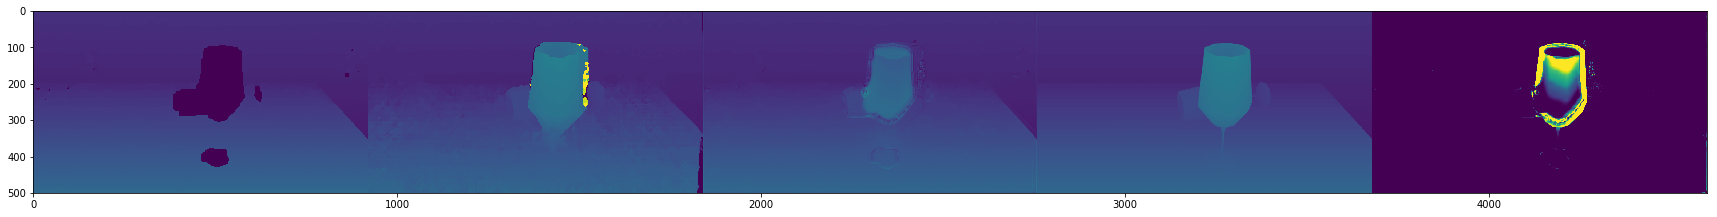

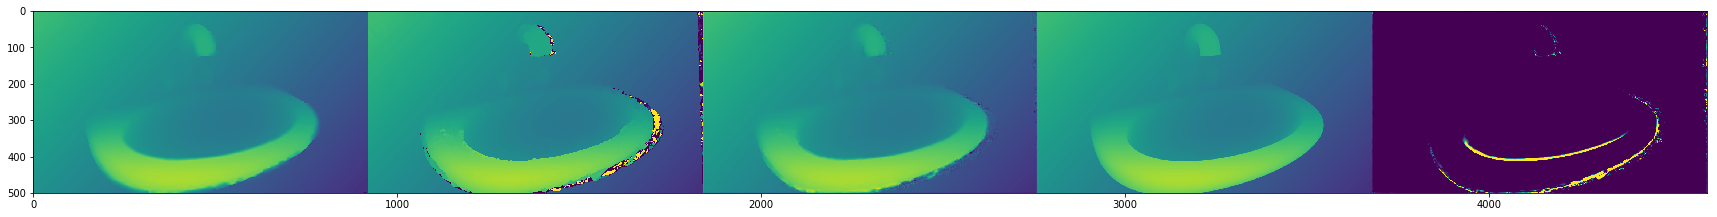

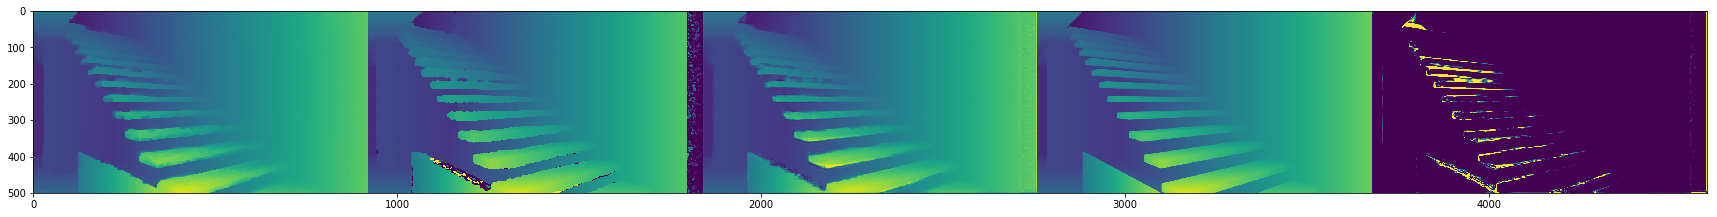

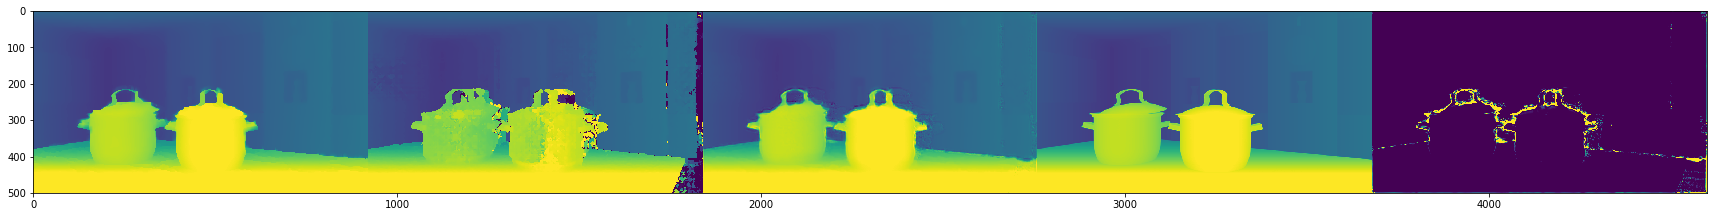

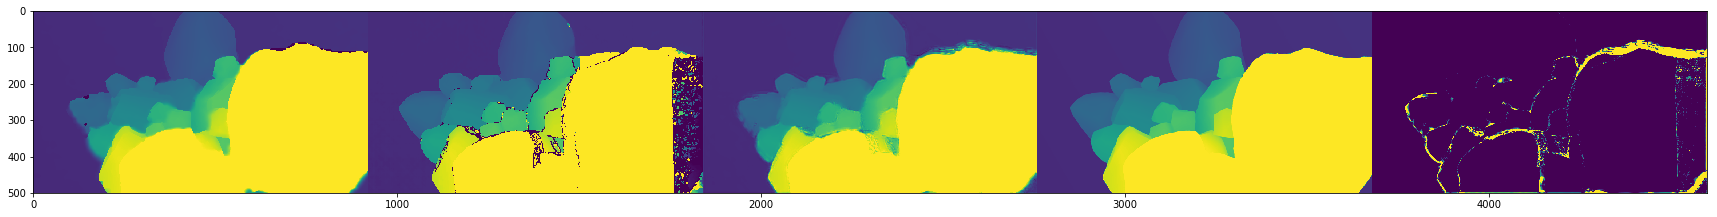

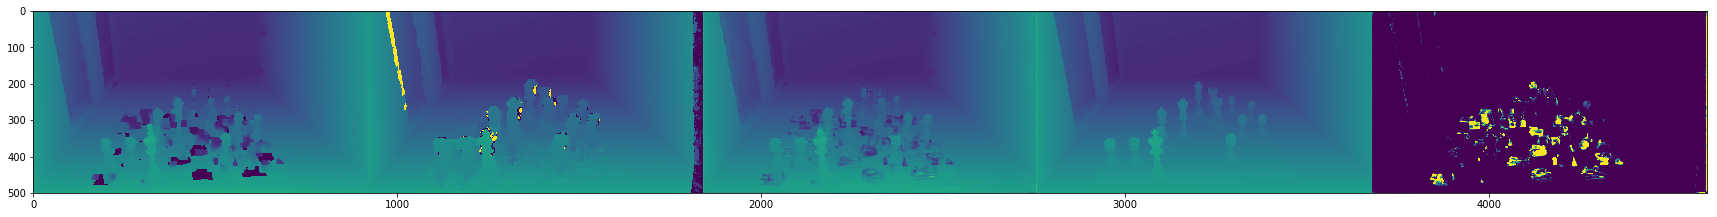

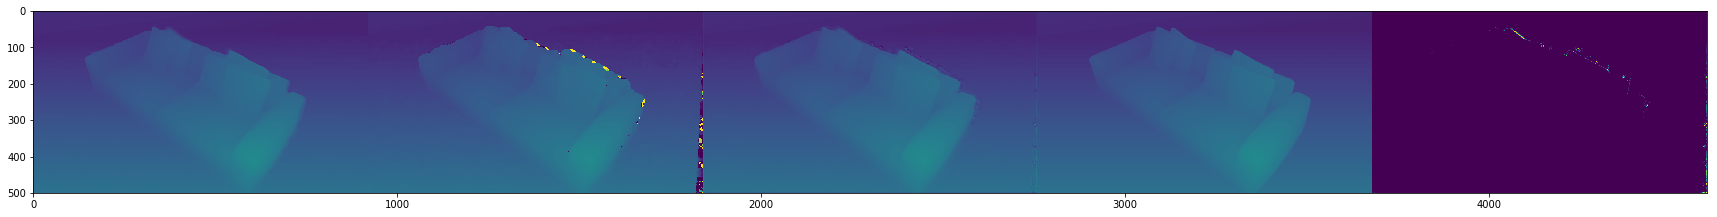

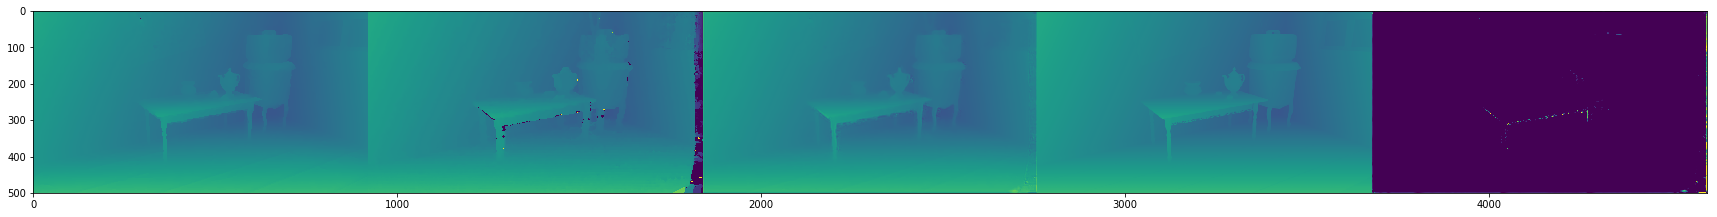

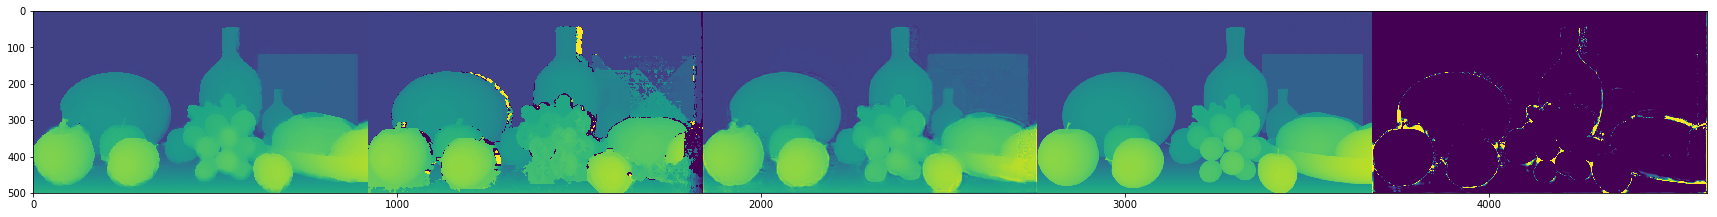

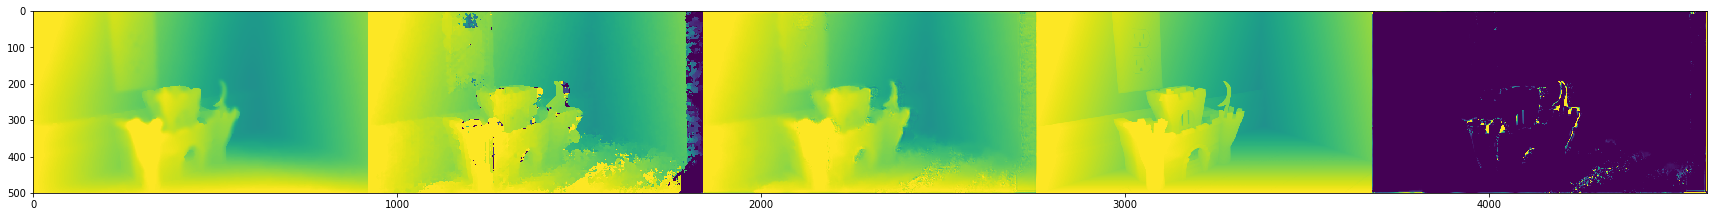

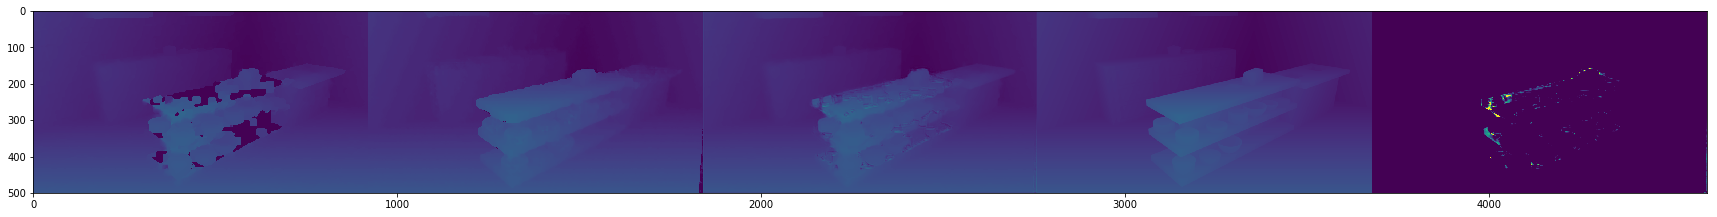

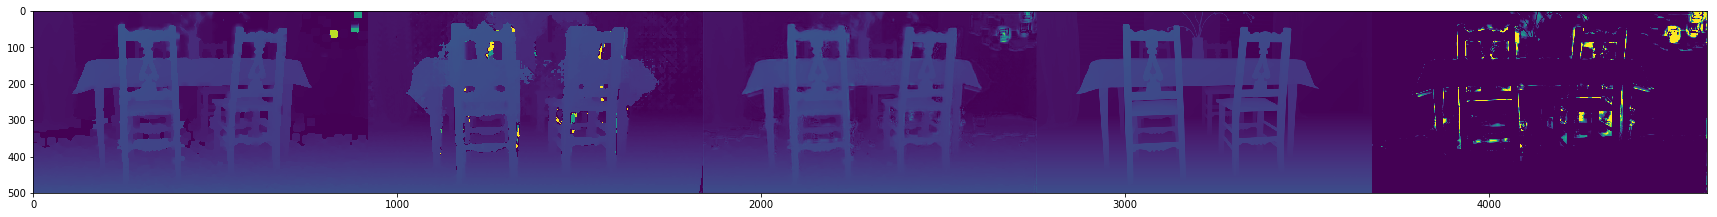

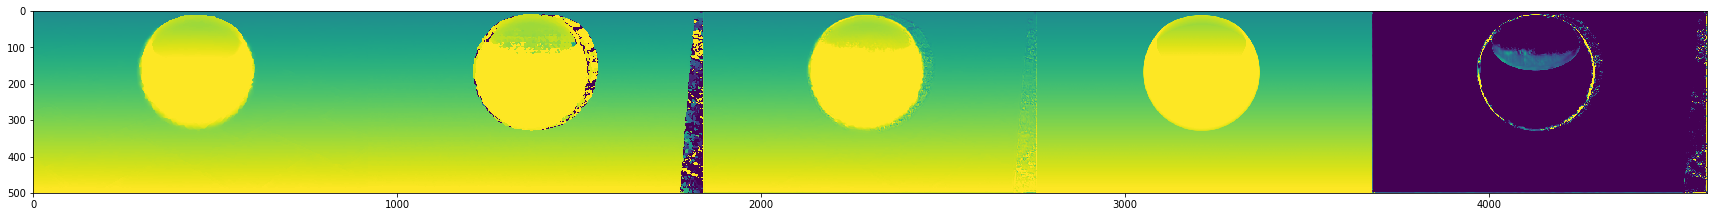

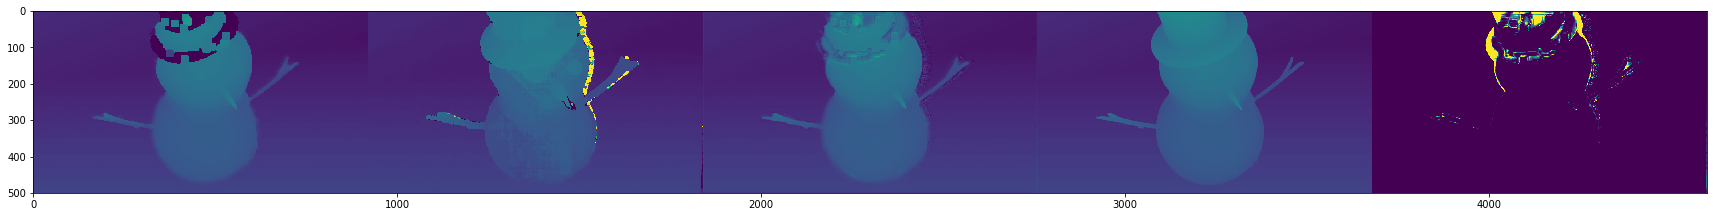

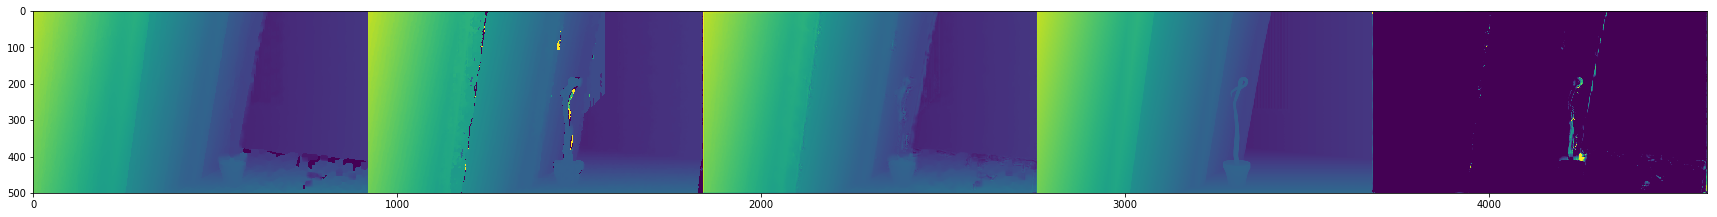

In [0]:
import matplotlib.pyplot as plt
import numpy as np

for batch in range(0, len(fused_images)):
  for i in range(0, len(fused_images[batch])):
      fused = np.squeeze(fused_images[batch][i])
      label = np.squeeze(label_images[batch][i])
      tof = np.squeeze(input_images[batch][i,:,:,1])
      stereo = np.squeeze(input_images[batch][i,:,:,0])
      difference = np.square(fused-label)

      plot_image = np.concatenate((tof, stereo, fused, label, difference), axis=1)
      plt.figure(figsize=(30, 30))
      plt.imshow(plot_image, vmin=10, vmax=80)
      plt.show()

    


In [0]:
# graph = tf.Graph()
# with graph.as_default():
#   tof = tf.placeholder(tf.float32, shape=[None, None, None])
#   label = tf.placeholder(tf.float32, shape=[None, None, None])
#   loss = tf.losses.mean_squared_error(tof,label)
  
# with tf.Session(graph=graph) as sess:
#   loss = sess.run(loss, feed_dict={tof: test_data[:,:,:,1], label: test_label[:,:,:,0]})
#   print(loss)